In [1]:
import numpy as np
import h5py
import keras
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense, Activation, Embedding
from keras.layers import Dropout, TimeDistributed, Bidirectional
from keras.layers import LSTM, ConvLSTM2D, BatchNormalization
from keras import regularizers
from keras import losses
import tensorflow as tf

import time

Using TensorFlow backend.


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Sundar_Notebooks")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Archive.zip		       FCLayers.ipynb	        RNN_Sundar.ipynb
 BasicCNN.ipynb		       model		        X_test.npy
 BasicCNN-varshinee.ipynb      person_test.npy	        X_train_valid.npy
 BiRNN_Sundar.ipynb	       person_train_valid.npy   y_test.npy
'CNN results log.docx'	       Prob_aggregation.ipynb   y_train_valid.npy
 CNN_results_log_Sundar.docx   RNN_Mathanky-66.ipynb


In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

X_train_valid = np.swapaxes(X_train_valid,1,2)
X_test= np.swapaxes(X_test,1,2)

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

y_train_valid -= 769
y_test -= 769

#person_train_valid -= 769
#person_test -= 769
#y_train_valid = keras.utils.to_categorical(y_train_valid, 4)
#y_test = keras.utils.to_categorical(y_test, 4)

Training/Valid data shape: (2115, 1000, 25)
Test data shape: (443, 1000, 25)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
import pywt
import matplotlib.pyplot as plt

feat_extract = False
num_signals = 25 ### 25 if using EOG, 22 otherwise

if feat_extract:
    mother = 'db4'
    levels = 3
    mode = 'zero'
    feats_train_valid = pywt.wavedec(X_train_valid,mother,axis = 1, level = levels, mode = mode)
    feats_train_valid = np.concatenate(feats_train,axis = 1)
    feats_test = pywt.wavedec(X_test,mother,axis = 1, level = levels, mode = mode)
    feats_test = np.concatenate(feats_test,axis = 1)
else:
    feats_train_valid = X_train_valid
    feats_test = X_test

feats_train_valid = feats_train_valid[:,:,0:num_signals]
feats_test = feats_test[:,:,0:num_signals]

feat_scale = 'on' ####making features 0 mean and unit variance

if feat_scale == 'on':
    temp = feats_train_valid - feats_train_valid.mean(axis=(0,1))
    temp = temp/feats_train_valid.std(axis=(0,1))
    feats_train_valid = temp
    temp = feats_test - feats_test.mean(axis=(0,1))
    temp = temp/feats_test.std(axis=(0,1))
    feats_test = temp
    
# f, ax = plt.subplots(5,5,figsize=(15,10))

# for i in np.arange(22):
#     idx = i%5
#     idy = i//5
#     ax[idy,idx].plot(feats_train[45,:,i])
# plt.show()

exp_mode = 'all' ## choices 'all','one_subject_train','one_subject_test'
val_split = 0.1

if exp_mode == 'one_subject_train':
    subject = 0
    temp = feats_train_valid[person_train_valid[:,0]==subject]
    mask = np.random.permutation(temp.shape[0])
    mask_train = mask[0:int((1-val_split)*mask.shape[0])]
    mask_val = mask[int((1-val_split)*mask.shape[0]):]
    feats_train = temp[mask_train]
    feats_val = temp[mask_val]
    temp2 = y_train_valid[person_train_valid[:,0]==subject]
    y_train = temp2[mask_train]
    y_val = temp2[mask_val]
    
elif exp_mode == 'one_subject_test':
    subject = 0
    temp = feats_train_valid[person_train_valid[:,0]!=subject]
    mask = np.random.permutation(temp.shape[0])
    mask_train = mask[0:int((1-val_split)*mask.shape[0])]
    mask_val = mask[int((1-val_split)*mask.shape[0]):]
    feats_train = temp[mask_train]
    feats_val = temp[mask_val]
    temp2 = y_train_valid[person_train_valid[:,0]!=subject]
    y_train = temp2[mask_train]
    y_val = temp2[mask_val]
    
    feats_test = None
    y_test = None
    feats_test = feats_train_valid[person_train_valid[:,0]==subject]
    y_test = y_train_valid[person_train_valid[:,0]==subject]

elif exp_mode == 'all':
    temp = feats_train_valid
    mask = np.random.permutation(temp.shape[0])
    mask_train = mask[0:int((1-val_split)*mask.shape[0])]
    mask_val = mask[int((1-val_split)*mask.shape[0]):]
    feats_train = temp[mask_train]
    feats_val = temp[mask_val]
    temp2 = y_train_valid
    y_train = temp2[mask_train]
    y_val = temp2[mask_val]
    

In [0]:
def birnn_model(features, labels, mode, params):
  
  num_hidden_layers = len(params['hidden_layers'])  
  
  input_layer = features["x"]    
 
  
  with tf.variable_scope("birnn_1") as scope:
    cell1 = tf.nn.rnn_cell.LSTMCell(num_units = params['hidden_layers'][0])
    cell2 = tf.nn.rnn_cell.LSTMCell(num_units = params['hidden_layers'][1])
    outputs_bi, state = tf.nn.bidirectional_dynamic_rnn(cell_fw=cell1,cell_bw=cell2,
                                     inputs=input_layer,
                                     dtype=tf.float64)

  outputs = tf.nn.relu(tf.concat(outputs_bi, 2))
  outputs = tf.layers.dropout(inputs=outputs, rate=0.6, training=(mode==tf.estimator.ModeKeys.TRAIN))
  outputs = tf.layers.batch_normalization(inputs=outputs)
  
#   with tf.variable_scope("birnn_2") as scope:
#     cell3 = tf.nn.rnn_cell.LSTMCell(num_units = params['hidden_layers'][2])
#     cell4 = tf.nn.rnn_cell.LSTMCell(num_units = params['hidden_layers'][3])
#     outputs_bi, state = tf.nn.bidirectional_dynamic_rnn(cell_fw=cell3,cell_bw=cell4,
#                                    inputs=outputs,
#                                    dtype=tf.float64)

#   outputs = tf.nn.relu(tf.concat(outputs_bi, 2))
#   outputs = tf.layers.dropout(inputs=outputs, rate=0.5, training=(mode==tf.estimator.ModeKeys.TRAIN))
#   outputs = tf.layers.batch_normalization(inputs=outputs)

  
  #FLatten the output of LSTM layers
  outputs = tf.contrib.layers.flatten(outputs) 
  
  outputs = tf.layers.dense(inputs=outputs, units=128)
  outputs = tf.nn.relu(outputs)
  
  outputs = tf.layers.dropout(inputs=outputs, rate=0.2, training=(mode==tf.estimator.ModeKeys.TRAIN))
  outputs = tf.layers.batch_normalization(inputs=outputs)

  # FC Layer
  logits = tf.layers.dense(inputs=outputs, units=params['num_classes'])

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
  tf.summary.scalar('loss', loss)
      

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

  merged = tf.summary.merge_all()
  train_writer = tf.summary.FileWriter(FLAGS.summaries_dir + '/train',
                                      sess.graph)
  test_writer = tf.summary.FileWriter(FLAGS.summaries_dir + '/test')

In [0]:
import warnings 
warnings.simplefilter('ignore')

In [14]:
#tf.reset_default_graph()
start = time.time()
eeg_classifier = tf.estimator.Estimator(model_fn=birnn_model, model_dir="model/", 
                                        params = {'hidden_layers' : [128,128], 'num_classes' : 4, 'learning_rate' : 0.001})
tensors_to_log = {"probabilities": "softmax_tensor"}
#logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": feats_train},
    y=y_train,
    batch_size=50,
    num_epochs=None,
    shuffle=True)

eeg_classifier.train(
    input_fn=train_input_fn,
    steps=10)
   #,hooks=[logging_hook])

eval_train_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": feats_train},
    y=y_train,
    num_epochs=1,
    shuffle=False)
eval_train_results = eeg_classifier.evaluate(input_fn=eval_train_fn)

eval_val_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": feats_val},
    y=y_val,
    num_epochs=1,
    shuffle=False)
eval_val_results = eeg_classifier.evaluate(input_fn=eval_val_fn)

eval_test_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": feats_test},
    y=y_test,
    num_epochs=1,
    shuffle=False)
eval_test_results = eeg_classifier.evaluate(input_fn=eval_test_fn)
print('Train results are:',eval_train_results)
print('Validation results are:',eval_val_results)
print('Test results are:',eval_test_results)
end = time.time()
print('Time taken in min:',(end-start)//60)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f16a52c8390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalize

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-70
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


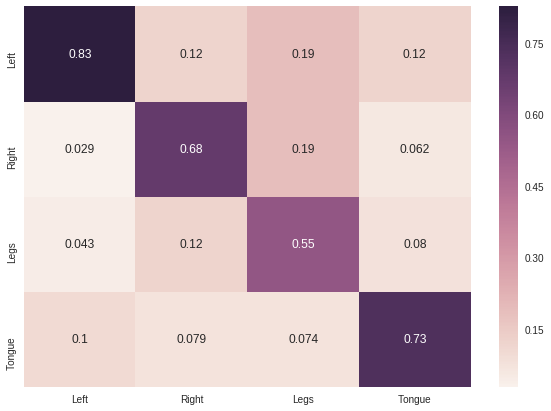

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

pred_fn = tf.estimator.inputs.numpy_input_fn(x={"x": feats_test},shuffle=False)
test_predi_info = eeg_classifier.predict(input_fn=pred_fn)
y_pred = []
for result in test_predi_info:
  y_pred.append(result['classes'])
y_pred = np.array(y_pred)
y_test_cm = np.load("y_test.npy") -769
labels = [0,1,2,3]
cm = confusion_matrix(y_test_cm,y_pred, labels)
cm = cm/cm.sum(axis=0)
df_cm = pd.DataFrame(cm, index = [i for i in ['Left','Right','Legs','Tongue']],
                  columns = [i for i in ['Left','Right','Legs','Tongue']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [16]:
pred_fn = tf.estimator.inputs.numpy_input_fn(x={"x": feats_test},shuffle=False)
test_predi_info = eeg_classifier.predict(input_fn=pred_fn)
y_prob_rnn = []
for result in test_predi_info:
  y_prob_rnn.append(result['probabilities'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-70
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


#### Setting some hyperparameters for the CNN architecture

In [0]:
y_train_cnn = keras.utils.to_categorical(y_train, 4)
y_val_cnn = keras.utils.to_categorical(y_val, 4)

y_test_cnn = keras.utils.to_categorical(y_test, 4)

In [0]:
num_classes = 4
N, W, C = feats_train.shape

In [0]:
L = 3 ### Number of layers (one layer is conv->activation->pooling->drpout->batchnorm)
p = 0.3 ## dropout probability
num_filters = 128 #### for convolutional layers
filter_shape = 3
pool_size = 3 ## size of pooling filters
dense_layer_size = 32

#### Definining the sequential model

The following cell defines the sequential model we will run. We will play around with different architectures and layers and log the error rates for each of these.

In [20]:
model = Sequential()
model.add(Conv1D(64, kernel_size=(filter_shape), strides=(1),
                 activation='relu',
                 input_shape=(W,C),padding = 'same'))
model.add(MaxPooling1D(pool_size=(pool_size), strides=(1)))
model.add(Dropout(p))
model.add(BatchNormalization())

#for l in np.arange(L-1):
model.add(Conv1D(128, kernel_size = (filter_shape), activation='relu',padding = 'same'))
model.add(MaxPooling1D(pool_size=(pool_size), strides=(2)))
model.add(Dropout(p))
model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size = (filter_shape), activation='relu',padding = 'same'))
model.add(MaxPooling1D(pool_size=(pool_size), strides=(2)))
model.add(Dropout(p))
model.add(BatchNormalization())

model.add(Conv1D(64, kernel_size = (filter_shape), activation='relu',padding = 'same'))
model.add(MaxPooling1D(pool_size=(pool_size), strides=(2)))
model.add(Dropout(p))
model.add(BatchNormalization())


# model.add(LSTM(128, activation='relu',return_sequences = True))
# model.add(Dropout(p))
# model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(dense_layer_size, activation='relu'))
model.add(Dropout(p))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# chk_path = os.path.join(model_dir, 'best_{}_{}'.format(NAME,t))
# checkpoint = ModelCheckpoint(chk_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# tensorboard = TensorBoard(log_dir="logs/{}_{}".format(NAME,t))
# callbacks_list = [checkpoint, tensorboard]

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1000, 64)          4864      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 998, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 998, 64)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 998, 64)           256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 998, 128)          24704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 498, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 498, 128)          0         
__________

#### Training and performance evaluation for the model above

Instructions for updating:
Use tf.cast instead.
Train on 1712 samples, validate on 191 samples
Epoch 1/40
1712/1712 [==============================] - 6s 3ms/step - loss: 1.8603 - acc: 0.2810 - val_loss: 1.5688 - val_acc: 0.3298
Epoch 2/40
1712/1712 [==============================] - 2s 1ms/step - loss: 1.3711 - acc: 0.4322 - val_loss: 1.5303 - val_acc: 0.3927
Epoch 3/40
1712/1712 [==============================] - 2s 1ms/step - loss: 1.1458 - acc: 0.5269 - val_loss: 1.5482 - val_acc: 0.4084
Epoch 4/40
1712/1712 [==============================] - 2s 1ms/step - loss: 0.9896 - acc: 0.6022 - val_loss: 1.1061 - val_acc: 0.5183
Epoch 5/40
1712/1712 [==============================] - 2s 1ms/step - loss: 0.8717 - acc: 0.6454 - val_loss: 1.0812 - val_acc: 0.5183
Epoch 6/40
1712/1712 [==============================] - 2s 1ms/step - loss: 0.8308 - acc: 0.6606 - val_loss: 0.9001 - val_acc: 0.6335
Epoch 7/40
1712/1712 [==============================] - 2s 1ms/step - loss: 0.7509 - acc: 0.6963 - va

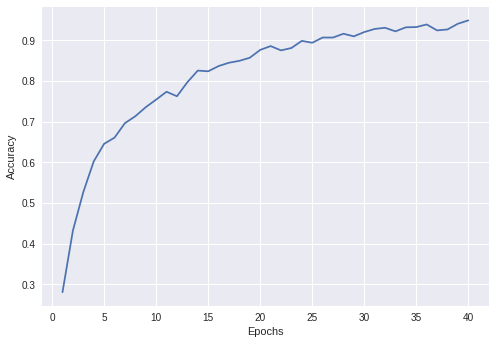

In [21]:
#### Hyperparameters for SGD####
epochs = 40
batch_size = 100

import time
start = time.time()
##### Training ######
model.fit(feats_train, y_train_cnn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.1,
          callbacks=[history], shuffle = True)


##### Testing #####
score = model.evaluate(feats_test, y_test_cnn, verbose=0)

end = time.time()

print('Time taken to train: {} minutes'.format((end-start)//60))

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs+1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

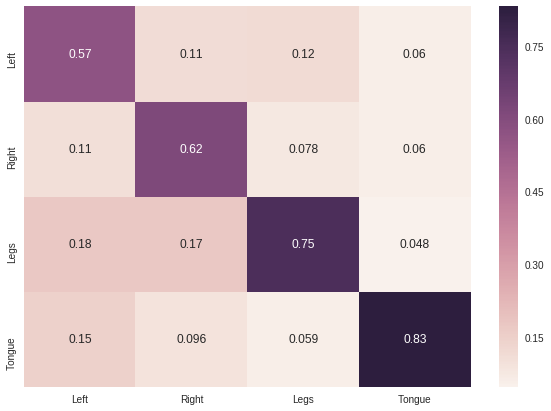

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
y_pred = []
y_pred =  model.predict(feats_test, verbose=0).argmax(axis=-1)

y_test_cm = np.load("y_test.npy") -769
labels = [0,1,2,3]
cm = confusion_matrix(y_test_cm,y_pred, labels)
cm = cm/cm.sum(axis=0)
df_cm = pd.DataFrame(cm, index = [i for i in ['Left','Right','Legs','Tongue']],
                  columns = [i for i in ['Left','Right','Legs','Tongue']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [0]:
y_prob_cnn = []
y_prob_cnn = model.predict(feats_test, verbose=0)
y_prob_cnn = np.array(y_prob_cnn)
y_prob_rnn = np.array(y_prob_rnn)


y_pred = (0.5*(y_prob_cnn+y_prob_rnn)).argmax(axis=-1)


In [58]:
y_pred.shape

(443,)

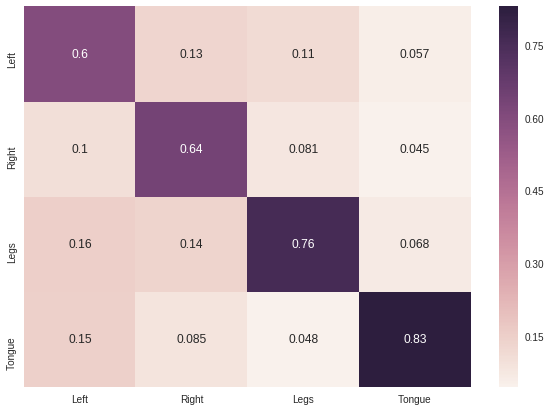

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_test_cm = np.load("y_test.npy") -769
labels = [0,1,2,3]
cm = confusion_matrix(y_test_cm,y_pred, labels)
cm = cm/cm.sum(axis=0)
df_cm = pd.DataFrame(cm, index = [i for i in ['Left','Right','Legs','Tongue']],
                  columns = [i for i in ['Left','Right','Legs','Tongue']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [60]:
(y_pred==y_test_cm).sum()/y_pred.shape[0]

0.6817155756207675